# Analyzing image Data in Keras

In [285]:
# Imports
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.cross_validation import train_test_split
from keras.callbacks import ModelCheckpoint 
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pickle
%matplotlib inline

np.random.seed(42)

## 1. Loading the data
This dataset is in json format. The following load_json function loads the whole dataset into a list in Python.

In [2]:
# Loading the data (it's preloaded in Keras)
def load_json(path='./data/train.json'):
    with open(path) as json_data:
        dta = json.load(json_data)
        json_data.close()
    return dta
dta =load_json(path='./data/train.json')

In [3]:
print('There are {} images in this dataset.'.format(len(dta)))
keys = list(dta[0].keys())
print('Each sample is a dictionary with {} keys.'.format(keys))
band_1 = dta[0]['band_1']
band_2 = dta[0]['band_2']
if len(band_1) == len(band_2):
    print('The lengths of band_1 and band_2 are the same and are equal with {}.'.format(len(band_1)))
    
is_iceberg = np.unique([dta[i]['is_iceberg'] for i in range(len(dta))])
print('The is_iceberg has the values of {}.'.format(is_iceberg))

There are 1604 images in this dataset.
Each sample is a dictionary with ['id', 'band_1', 'band_2', 'inc_angle', 'is_iceberg'] keys.
The lengths of band_1 and band_2 are the same and are equal with 5625.
The is_iceberg has the values of [0 1].


To further study the characteristics of the data, histograms of band_1 and band_2 are plotted as follows:

In [4]:
def flatten_data(json_data=dta):
    ##
    samples_len = len(json_data)
    model_target = []
    sample = []
    band_1 = []
    band_2 = []
    inc_angle = []
    ##
    for sample_n in range(samples_len):
        #
        model_target_temp = [json_data[sample_n]['is_iceberg']]*len(json_data[sample_n]['band_1'])
        model_target.extend(model_target_temp)
        ##
        sample_temp = [sample_n]*len(json_data[sample_n]['band_1'])
        sample.extend(sample_temp)
        ##
        inc_angle_temp = [json_data[sample_n]['inc_angle']]*len(json_data[sample_n]['band_1'])
        inc_angle.extend(inc_angle_temp)
        ##
        band_1 += json_data[sample_n]['band_1']
        band_2 += json_data[sample_n]['band_2']
        ##
    ##
    return band_1, band_2, inc_angle, model_target, sample
band_1, band_2, inc_angle, model_target, sample = flatten_data(json_data=dta)

In [5]:
## converting data to a pandas dataframe
dc = {'band_1':band_1, 'band_2':band_2, 'inc_angle':inc_angle, 'target':model_target, 'sample':sample}
df = pd.DataFrame(dc)
df.head(4)

,band_1,band_2,inc_angle,sample,target
0,-27.878361,-27.154118,43.9239,0,0
1,-27.154160,-29.537888,43.9239,0,0
2,-28.668615,-31.030600,43.9239,0,0
3,-29.537971,-32.190483,43.9239,0,0


## 2. Exploring the data

In [66]:
df_2 = pd.DataFrame()
df_2['target'] = df.groupby('sample')['sample', 'target'].apply(lambda x: np.unique(x.target)[0])
df_2.reset_index(drop=False, inplace=True)

**The following barchart shows the counts of images with (1) and without (0) iceberg.**

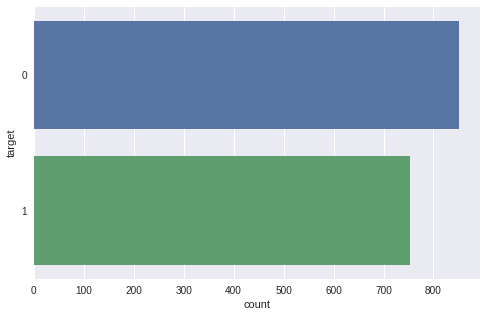

In [151]:
fig = plt.figure(figsize=(8,5))
sns.countplot(y="target", data=df_2)

**The following histograms show the distribution of band_1, band_2, and inc_angle values.**

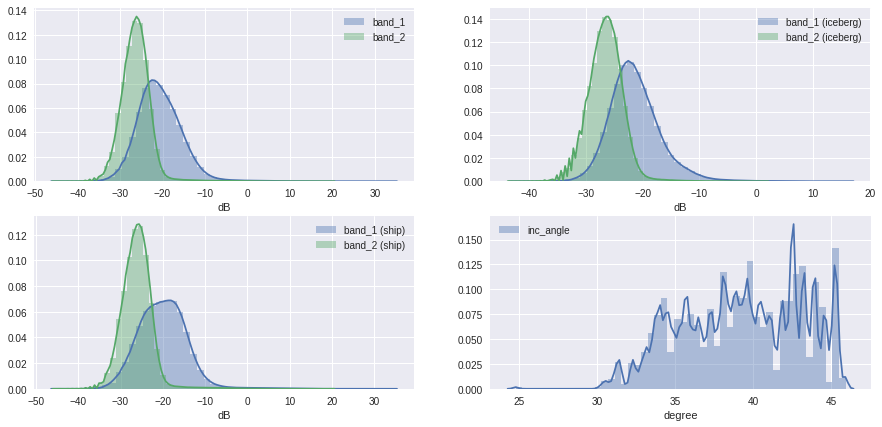

In [104]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(2, 2, 1)
sns.distplot(df.band_1, label='band_1')
sns.distplot(df.band_2, label='band_2')
plt.legend()
plt.xlabel('dB')

ax = fig.add_subplot(2, 2, 2)
sns.distplot(df[df.target==1]['band_1'], label='band_1 (iceberg)')
sns.distplot(df[df.target==1]['band_2'], label='band_2 (iceberg)')
plt.legend()
plt.xlabel('dB')

ax = fig.add_subplot(2, 2, 3)
sns.distplot(df[df.target==0]['band_1'], label='band_1 (ship)')
sns.distplot(df[df.target==0]['band_2'], label='band_2 (ship)')
plt.legend()
plt.xlabel('dB')

ax = fig.add_subplot(2, 2, 4)
sns.distplot(df[df.inc_angle!='na']['inc_angle'], label='inc_angle')
plt.legend()
plt.xlabel('degree')

## 3. Preparing the data

In the next step, the values of band_1 and band_2 are used to construct images with three channels that can be used to train a benchmark model and also to extract bottleneck features using VGG-16 and ResNet-50 architectures. The is_iceberg values are the models target (y) with values of 1 and 0 corresponding to images with iceberg and without iceberg respectively. Here a function is created that does the data conversion task.

In [136]:
def convert_data(json_data=dta):
    ##
    samples_len = len(json_data)
    width = int(np.sqrt(len(json_data[0]['band_1'])))
    height = width
    ##
    model_input = np.zeros(shape=(samples_len, width, height, 3))
    model_target = np.zeros(shape=(samples_len, 1))
    ##
    for sample_n in range(samples_len):
        ##
        band_1 = np.array(json_data[sample_n]['band_1'])
        band_1 += abs(min(band_1))
        band_1 *= 255/max(band_1)
        #
        band_2 = np.array(json_data[sample_n]['band_2'])
        band_2 += abs(min(band_2))
        band_2 *= 255/max(band_2)
        ##
        image = list(band_1) + list(band_2) + list(band_2)
        image_reshaped = np.reshape(image, [width, height, 3])
        ##
        model_input[sample_n] = image_reshaped
        ##
        model_target[sample_n] = json_data[sample_n]['is_iceberg']
    ##
    return model_input, model_target

In [137]:
model_input, model_target = convert_data(json_data=dta)

In [140]:
model_input.shape

(1604, 75, 75, 3)

## 4. Splitting data into train and validation sets
Here, the model_input dataset is divided into train and validation sets.

In [156]:
X_train, X_val, y_train, y_val = train_test_split(model_input, model_target, test_size=0.20, random_state=19)

In [192]:
X_train.shape

(1283, 75, 75, 3)

## 5. Building the benchmark  model architecture
Here, the benchmark CNN model architecture is constructed.

In [231]:
def construct_benchmark(inp):
    ##
    model = Sequential()
    ##
    model.add(Conv2D(filters=16, kernel_size=2, strides=1, padding='same', activation='relu',
                     input_shape=inp.shape[1:]))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64, kernel_size=2, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [232]:

benchmark = construct_benchmark(inp=X_train)
benchmark.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_91 (Conv2D)           (None, 75, 75, 16)        208       
_________________________________________________________________
max_pooling2d_89 (MaxPooling (None, 37, 37, 16)        0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 37, 37, 32)        2080      
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 18, 18, 64)        8256      
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
global_average_pooling2d_27  (None, 64)                0         
__________

In [233]:

adam = Adam(lr=0.00015)
benchmark.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])

##
checkpointer = ModelCheckpoint(filepath='./weights/benchmark_weights.hdf5',
                               monitor='val_acc',
                               verbose=1,
                               save_best_only=True,
                               mode='max')

hist_1 = benchmark.fit(X_train, y_train,
                     batch_size=32,
                     validation_data=(X_val, y_val),
                     epochs=200,
                     callbacks=[checkpointer],
                     verbose=0)

Epoch 00000: val_acc improved from -inf to 0.46729, saving model to ./weights/benchmark_weights.hdf5
Epoch 00001: val_acc improved from 0.46729 to 0.53271, saving model to ./weights/benchmark_weights.hdf5
Epoch 00002: val_acc improved from 0.53271 to 0.61059, saving model to ./weights/benchmark_weights.hdf5
Epoch 00003: val_acc improved from 0.61059 to 0.65732, saving model to ./weights/benchmark_weights.hdf5
Epoch 00004: val_acc improved from 0.65732 to 0.67601, saving model to ./weights/benchmark_weights.hdf5
Epoch 00005: val_acc did not improve
Epoch 00006: val_acc did not improve
Epoch 00007: val_acc did not improve
Epoch 00008: val_acc did not improve
Epoch 00009: val_acc improved from 0.67601 to 0.68536, saving model to ./weights/benchmark_weights.hdf5
Epoch 00010: val_acc did not improve
Epoch 00011: val_acc improved from 0.68536 to 0.69470, saving model to ./weights/benchmark_weights.hdf5
Epoch 00012: val_acc did not improve
Epoch 00013: val_acc improved from 0.69470 to 0.71028

Epoch 00180: val_acc did not improve
Epoch 00181: val_acc did not improve
Epoch 00182: val_acc did not improve
Epoch 00183: val_acc did not improve
Epoch 00184: val_acc did not improve
Epoch 00185: val_acc did not improve
Epoch 00186: val_acc did not improve
Epoch 00187: val_acc did not improve
Epoch 00188: val_acc did not improve
Epoch 00189: val_acc did not improve
Epoch 00190: val_acc did not improve
Epoch 00191: val_acc did not improve
Epoch 00192: val_acc did not improve
Epoch 00193: val_acc did not improve
Epoch 00194: val_acc did not improve
Epoch 00195: val_acc did not improve
Epoch 00196: val_acc did not improve
Epoch 00197: val_acc did not improve
Epoch 00198: val_acc did not improve
Epoch 00199: val_acc did not improve


In [235]:
def plot_history(hist, title=''):
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title(title)
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

**The following figure shows how the train and vlidation accuracy scores change by epoch.**

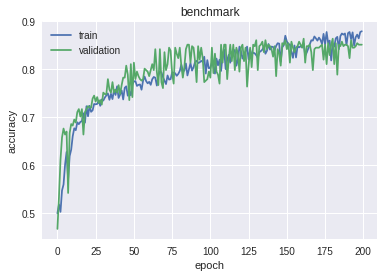

In [236]:
plot_history(hist=hist_1, title='benchmark')

In [237]:
model = construct_benchmark(inp=inp)
model.load_weights('./weights/benchmark_weights.hdf5')
model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
benchmark_score = model.evaluate(X_val, y_val, verbose=0)
print("The {} accuracy is: {:.3f}".format('benchmark', benchmark_score[1]))


## 6. Adding layers to the benchmark model

**In the next step, more layers are added to the model.**

In [278]:
def construct_model(inp=X_train):
    ##
    model = Sequential()
    ##
    model.add(Conv2D(filters=16, kernel_size=2, strides=1, padding='same', activation='relu',
                     input_shape=inp.shape[1:]))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64, kernel_size=2, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=128, kernel_size=2, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1260, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(660, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model


In [279]:
model_1 = construct_model(inp=X_train)
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_157 (Conv2D)          (None, 75, 75, 16)        208       
_________________________________________________________________
max_pooling2d_155 (MaxPoolin (None, 37, 37, 16)        0         
_________________________________________________________________
conv2d_158 (Conv2D)          (None, 37, 37, 32)        2080      
_________________________________________________________________
max_pooling2d_156 (MaxPoolin (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_159 (Conv2D)          (None, 18, 18, 64)        8256      
_________________________________________________________________
max_pooling2d_157 (MaxPoolin (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 9, 9, 128)         32896     
__________

In [280]:
adam = Adam(lr=0.00015)
model_1.compile(loss='binary_crossentropy',
                optimizer=adam,
                metrics=['accuracy'])

##
checkpointer = ModelCheckpoint(filepath='./weights/model_1_weights.hdf5',
                               monitor='val_acc',
                               verbose=1,
                               save_best_only=True,
                               mode='max')

hist_2 = model_1.fit(X_train, y_train, 
                   batch_size=32,
                   validation_data=(X_val, y_val),
                   epochs=200,
                   callbacks=[checkpointer], 
                   verbose=0)

Epoch 00000: val_acc improved from -inf to 0.58255, saving model to ./weights/model_1_weights.hdf5
Epoch 00001: val_acc improved from 0.58255 to 0.66044, saving model to ./weights/model_1_weights.hdf5
Epoch 00002: val_acc improved from 0.66044 to 0.67290, saving model to ./weights/model_1_weights.hdf5
Epoch 00003: val_acc did not improve
Epoch 00004: val_acc improved from 0.67290 to 0.68224, saving model to ./weights/model_1_weights.hdf5
Epoch 00005: val_acc improved from 0.68224 to 0.70093, saving model to ./weights/model_1_weights.hdf5
Epoch 00006: val_acc improved from 0.70093 to 0.70405, saving model to ./weights/model_1_weights.hdf5
Epoch 00007: val_acc did not improve
Epoch 00008: val_acc improved from 0.70405 to 0.72897, saving model to ./weights/model_1_weights.hdf5
Epoch 00009: val_acc improved from 0.72897 to 0.73520, saving model to ./weights/model_1_weights.hdf5
Epoch 00010: val_acc did not improve
Epoch 00011: val_acc did not improve
Epoch 00012: val_acc improved from 0.73

Epoch 00194: val_acc did not improve
Epoch 00195: val_acc did not improve
Epoch 00196: val_acc did not improve
Epoch 00197: val_acc did not improve
Epoch 00198: val_acc did not improve
Epoch 00199: val_acc did not improve


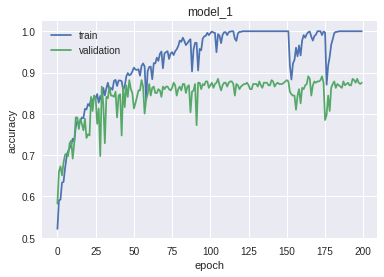

In [281]:
plot_history(hist=hist_2, title='model_1')

In [282]:
model = construct_model(inp=X_train)
model.load_weights('./weights/model_1_weights.hdf5')
model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
model_1_score = model.evaluate(X_val, y_val, verbose=0)
print("The {} accuracy is: {:.3f}".format('model_1', model_1_score[1]))

The model_1 accuracy is: 0.891


## 7. Extracting bottleneck features
**In the following steps, the ResNet50 bottleneck features are extracted and used for the prediction.**

**First, the following function is used to extract and save the ResNet50 bottleneck features.**

In [ ]:
from extract_bottleneck_features import *

def extract_ResNet50_features(json_data=dta):
    ##
    samples_len = len(json_data)
    width = int(np.sqrt(len(json_data[0]['band_1'])))
    height = width
    ##
    model_input = np.zeros(shape=(samples_len, 2, 2, 2048))
    model_target = np.zeros(shape=(samples_len, 1))
    ##
    n=0
    for sample_n in range(samples_len):
        ##
        n += 1
        
        ##
        band_1 = json_data[sample_n]['band_1']
        band_1 = np.array(band_1)
        band_1 = band_1 + abs(min(band_1))
        band_1 = band_1*255/max(band_1)
        
        ##
        band_2 = json_data[sample_n]['band_2']
        band_2 = np.array(band_2)
        band_2 = band_2 + abs(min(band_2))
        band_2 = band_2*255/max(band_2)
        
        ##
        image = list(band_1) + list(band_2) + list(band_2)
        
        ##
        image_reshaped = np.reshape(image, [width, height, 3])
        ## to resize the image so it can be fed into Resnet50 model
        image_reshaped = scipy.misc.imresize(image_reshaped, (256, 256, 3))
        image_reshaped = image_reshaped.astype('float32')

        ## too clear the session and free the memory
        if n>10:
            K.clear_session()
            n = 0
        ##
        bottleneck_feature = extract_Resnet50(np.expand_dims(image_reshaped, axis=0))
        
        ##
        model_input[sample_n] = bottleneck_feature
        
        ##
        model_target[sample_n] = json_data[sample_n]['is_iceberg']
    ##
    return model_input, model_target

** The following block can be used to extract and save the bottleneck features.**

** The following function is used to load the bottleneck features.** 

In [283]:
def load_bottleneckFeatures(path):
    with (open(path, "rb")) as openfile:
        features = pickle.load(openfile)
    return features

In [287]:
bottleneckFeatures = load_bottleneckFeatures(path='./bottleneck_features/ResNet50_features.pkl')


In [289]:
bottleneckFeatures.keys()

dict_keys(['features', 'target'])

** Here, the loaded dataset is divided into train and validation.**

In [ ]:
def model_ResNet50(inp=bottleneckFeatures['features']):
    ResNet50_model = Sequential()
    # InceptionV3_model.add(Dense(860, input_dim=inp.shape[1:], activation='relu'))
    ResNet50_model.add(GlobalAveragePooling2D(input_shape=inp.shape[1:]))
    ResNet50_model.add(Dense(860, activation='relu'))
    ResNet50_model.add(Dropout(0.5))
    ResNet50_model.add(Dense(460, activation='relu'))
    ResNet50_model.add(Dropout(0.5))
    # ResNet50_model.add(Dense(10, activation='relu'))
    # ResNet50_model.add(Dropout(0.5))
    # ResNet50_model.add(Dense(160, activation='relu'))
    # ResNet50_model.add(Dropout(0.5))
    ResNet50_model.add(Dense(1, activation='sigmoid'))
    return ResNet50_model

In [288]:
ResNet50_model = model_ResNet50()
ResNet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_46  (None, 2048)              0         
_________________________________________________________________
dense_110 (Dense)            (None, 860)               1762140   
_________________________________________________________________
dropout_73 (Dropout)         (None, 860)               0         
_________________________________________________________________
dense_111 (Dense)            (None, 460)               396060    
_________________________________________________________________
dropout_74 (Dropout)         (None, 460)               0         
_________________________________________________________________
dense_112 (Dense)            (None, 1)                 461       
Total params: 2,158,661
Trainable params: 2,158,661
Non-trainable params: 0
_________________________________________________________________
